### Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_forecasting-USU/blob/main/Lectures%20and%20codes/Module%205-%20Machine%20Learning%20Forecasting/Module5-DT_intuition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center) 


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


## Prediction intervals for Machine Learening timeseries: 

In classical statistical models (like ARIMA, ETS), prediction intervals can be calculated analytically because:

* They make assumptions about error distributions (usually normal)
* They have closed-form expressions for parameter uncertainty
* They have well-defined statistical theory for error propagation


For ML models like Random Forest, there are several challenges:

* No assumptions about error distributions
* No closed-form expressions for uncertainty
* In recursive forecasting (multi-step ahead), errors compound in complex ways that are hard to quantify
* The model's internal randomness (like bagging in Random Forest) doesn't directly translate to prediction uncertainty


However, there are ways to get prediction intervals with ML models, just not implemented in PyCaret currently:

1. Bootstrap methods
2. Quantile Regression
3. Conformal Prediction


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

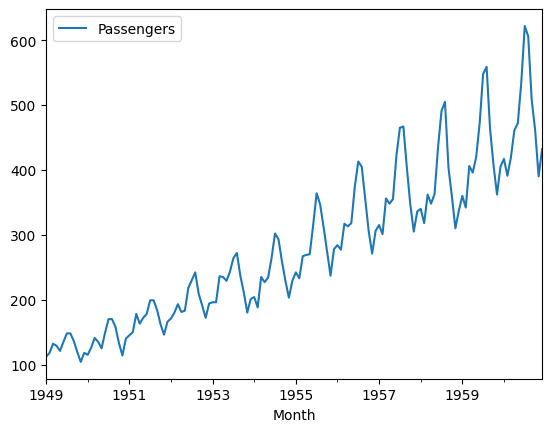

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/airline_passengers.csv", index_col="Month")
data.index = pd.to_datetime(data.index)
data.plot()
plt.show()

## 1. Bootstrap methods
Prediction intervals with bootstrapping provide a way to estimate the range of possible future values by capturing uncertainty in the forecast. Here’s how it works:

Bootstrapping: Repeatedly resamples your original dataset with replacement to create many new "bootstrapped" datasets.

Model Training: A separate model is trained on each bootstrapped dataset, producing a collection of predictions for each time point.

Prediction Interval: By looking at the spread of these predictions (e.g., taking the 5th and 95th percentiles), you get a range— or prediction interval—that shows where the true values are likely to fall.

This method is useful in time series forecasting because it doesn't assume a specific error distribution and can provide more robust intervals, especially in cases with complex data patterns or when traditional assumptions don’t hold.

### One-Step ahead prediction intervals

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

def create_one_step_ahead_prediction_intervals(
    data,
    target_col,
    n_lags=12,
    train_size=0.90,
    model=None,
    n_boot=100,
    random_state=101,
    lower_bound=2.5,
    upper_bound=97.5
):
    """
    Create prediction intervals for time series data using bootstrap
    
    Parameters:
    -----------
    data : pd.DataFrame or pd.Series
        Time series data
    target_col : str
        Name of target column (only needed if data is DataFrame)
    n_lags : int
        Number of lags to create
    train_size : float
        Proportion of data to use for training (0 to 1)
    model : sklearn model
        Any sklearn regression model (RF, XGBoost, etc.)
    n_boot : int
        Number of bootstrap samples
    random_state : int
        Random seed for reproducibility
    lower_bound : float
        Lower percentile for prediction interval
    upper_bound : float
        Upper percentile for prediction interval
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing actual values, predictions, and prediction intervals
    """
    # Set random seed
    np.random.seed(random_state)
    
    # Convert to series if DataFrame
    if isinstance(data, pd.DataFrame):
        series = data[target_col]
    else:
        series = data
        
    # Create features
    df = pd.DataFrame()
    
    # Create lag features
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = series.shift(i)
    
    # Add target
    df['target'] = series
    
    # Remove rows with NaN values
    df = df.dropna()
    
    # Split into X and y
    y = df['target']
    X = df.drop('target', axis=1)
    
    # Split into train/test
    train_size = int(len(X) * train_size)
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    # Bootstrap predictions
    predictions = []
    
    for i in range(n_boot):
        # Bootstrap samples
        indices = resample(range(len(X_train)), n_samples=len(X_train))
        X_boot = X_train.iloc[indices]
        y_boot = y_train.iloc[indices]
        
        # Fit and predict
        model.fit(X_boot, y_boot)
        pred = model.predict(X_test)
        predictions.append(pred)
    
    # Convert to array
    predictions = np.array(predictions)
    
    # Calculate intervals
    mean_pred = np.mean(predictions, axis=0)
    lower = np.percentile(predictions, lower_bound, axis=0)
    upper = np.percentile(predictions, upper_bound, axis=0)
    
    # Create results DataFrame
    results = pd.DataFrame({
        'actual': y_test,
        'prediction': mean_pred,
        'lower_bound': lower,
        'upper_bound': upper
    }, index=y_test.index)
    
    # Calculate metrics
    mape = np.mean(np.abs((results['actual'] - results['prediction']) / results['actual'])) * 100
    rmse = np.sqrt(np.mean((results['actual'] - results['prediction'])**2))
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.plot(y_train.index, y_train, label='Training Data', alpha=0.5)
    
    # Plot test data and predictions
    plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2, alpha=0.3)
    plt.plot(y_test.index, mean_pred, label='Predictions', color='blue', linewidth=2)
    
    # Plot prediction intervals
    plt.fill_between(y_test.index, lower, upper, 
                     alpha=0.2, color='blue', 
                     label=f'{lower_bound}% - {upper_bound}% Prediction Intervals')
    
    plt.title('Time Series Forecast with Bootstrap Prediction Intervals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f}")

    
    return results


In [4]:
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

Training set shape: (120, 12)
Test set shape: (12, 12)


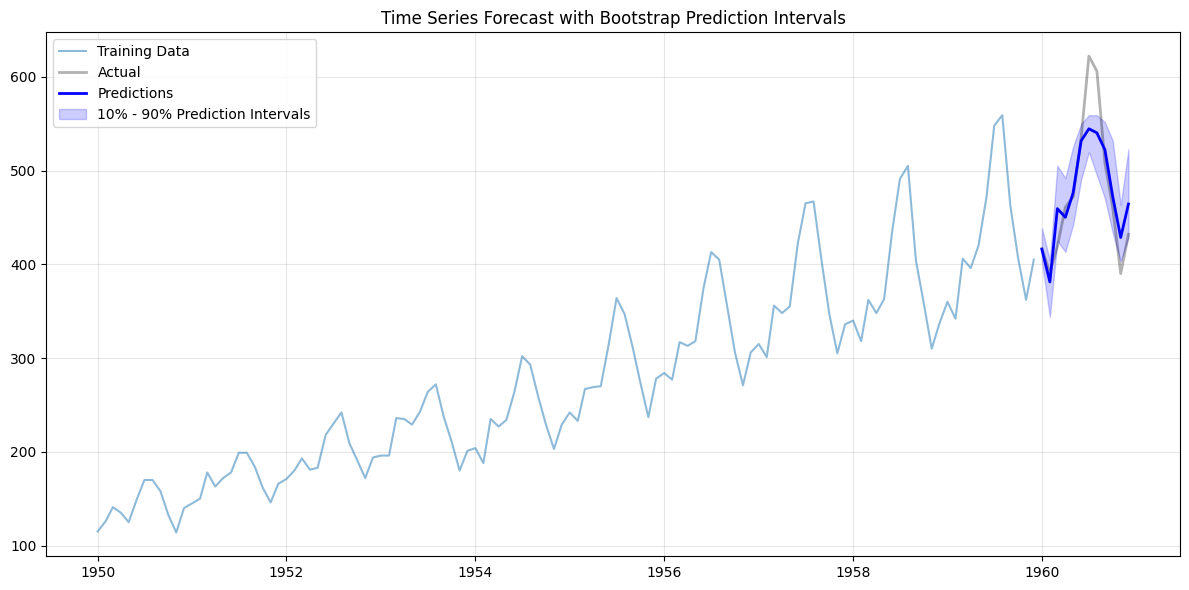


Summary Statistics:
MAPE: 5.19%
RMSE: 35.44


,actual,prediction,lower_bound,upper_bound
Month,,,,
1960-01-01,417,416.0566,402.925,438.980
1960-02-01,391,381.1701,343.841,404.056
1960-03-01,419,459.3649,425.043,505.176
1960-04-01,461,450.1165,413.265,492.083
1960-05-01,472,476.3416,442.252,525.408


In [6]:
# Create and use the function
results = create_one_step_ahead_prediction_intervals(
    data=data,
    target_col='Passengers',
    n_lags=12,
    train_size=0.91,
    model=RandomForestRegressor(bootstrap=False),
    n_boot=100,
    lower_bound=10,
    upper_bound=90)

results.head()  

### Multi-step ahead prediction intervals

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

def create_multi_step_ahead_prediction_intervals(
    data,
    target_col,
    n_lags=12,
    train_size=0.90,
    fh=12,
    model=None,
    n_boot=100,
    random_state=101,
    lower_bound=2.5,
    upper_bound=97.5
):
    """[previous docstring remains the same]"""
    
    # Set random seed
    np.random.seed(random_state)
    
    # Convert to series if DataFrame
    if isinstance(data, pd.DataFrame):
        series = data[target_col]
    else:
        series = data
        
    # Create features
    df = pd.DataFrame()
    
    # Create lag features
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = series.shift(i)
    
    # Add target
    df['target'] = series
    
    # Remove rows with NaN values
    df = df.dropna()
    
    # Split into X and y
    y = df['target']
    X = df.drop('target', axis=1)
    
    # Split into train/test
    train_size = int(len(X) * train_size)
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    # Bootstrap predictions
    predictions = np.zeros((n_boot, fh))
    
    for b in range(n_boot):
        # Bootstrap samples
        indices = resample(range(len(X_train)), n_samples=len(X_train))
        X_boot = X_train.iloc[indices]
        y_boot = y_train.iloc[indices]
        
        # Fit model on bootstrapped data
        model.fit(X_boot, y_boot)
        
        # Get last n_lags values for the first prediction
        last_known = y_train.iloc[-n_lags:].values
        
        # Make recursive predictions
        boot_predictions = []
        for step in range(fh):
            # Prepare features for this step
            X_step = pd.DataFrame([{f'lag_{i+1}': last_known[-(i+1)] 
                                  for i in range(n_lags)}])
            
            # Ensure columns are in the same order as training data
            X_step = X_step[X_train.columns]
            
            # Make prediction
            pred = model.predict(X_step)[0]
            boot_predictions.append(pred)
            
            # Update last_known values for next step
            last_known = np.append(last_known[1:], pred)
        
        predictions[b, :] = boot_predictions
    
    # Calculate intervals
    mean_pred = np.mean(predictions, axis=0)
    lower = np.percentile(predictions, lower_bound, axis=0)
    upper = np.percentile(predictions, upper_bound, axis=0)
    
    # Create future dates for predictions
    if isinstance(y_train.index, pd.PeriodIndex):
        # For PeriodIndex, create future periods then convert to timestamp for plotting
        future_dates = pd.period_range(
            start=y_train.index[-1] + 1,
            periods=fh,
            freq=y_train.index.freq
        )
        plot_dates = future_dates.to_timestamp()
        y_train_plot = y_train.copy()
        y_train_plot.index = y_train.index.to_timestamp()
    else:
        # For DatetimeIndex
        freq = pd.infer_freq(y_train.index)
        future_dates = pd.date_range(
            start=y_train.index[-1],
            periods=fh + 1,
            freq=freq
        )[1:]  # Exclude the start date
        plot_dates = future_dates
        y_train_plot = y_train
    
    # Create results DataFrame
    results = pd.DataFrame({
        'prediction': mean_pred,
        'lower_bound': lower,
        'upper_bound': upper
    }, index=future_dates)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot all training data
    plt.plot(y_train_plot.index, y_train_plot, label='Training Data', alpha=0.5)

    # plot the actual values
    plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2, alpha=0.3)
    
    # Plot predictions and intervals
    plt.plot(plot_dates, mean_pred, 
             label='Predictions', color='blue', linewidth=2)
    plt.fill_between(plot_dates, lower, upper, 
                     alpha=0.2, color='blue', 
                     label=f'{lower_bound}% - {upper_bound}% Prediction Intervals')
    
    plt.title('Multi-step Ahead Forecast with Bootstrap Prediction Intervals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    
    return results

Training set shape: (120, 12)
Test set shape: (12, 12)


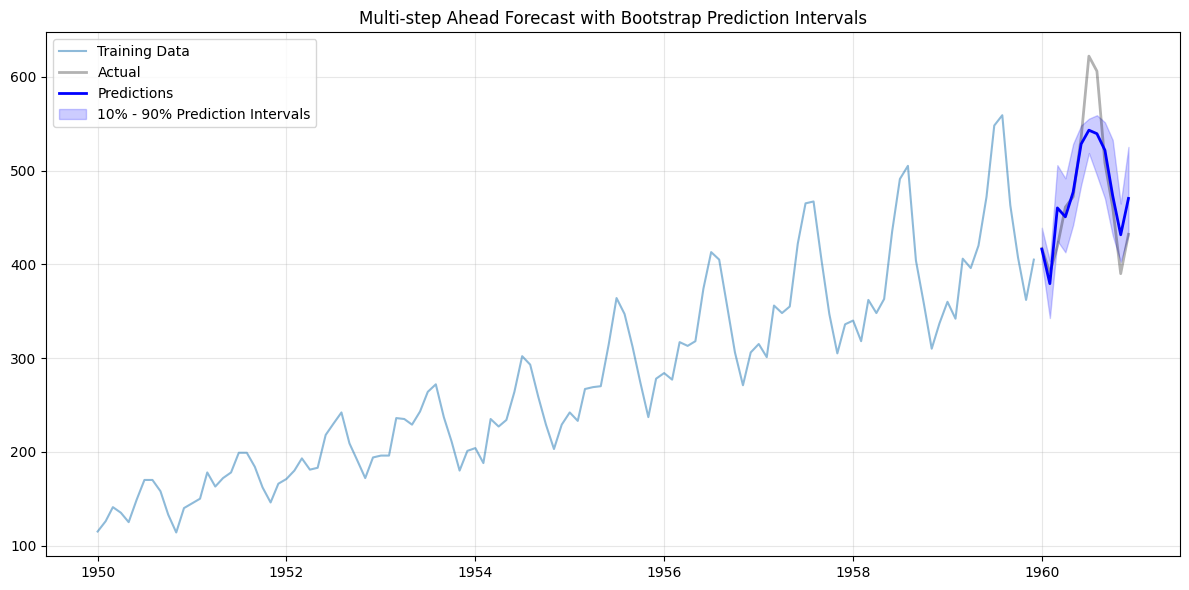

,prediction,lower_bound,upper_bound
1960-01-01,416.0566,402.925,438.980
1960-02-01,379.3494,342.706,403.501
1960-03-01,460.1396,425.037,505.747
1960-04-01,450.6337,412.823,491.701
1960-05-01,476.9473,441.953,528.396


In [9]:
results = create_multi_step_ahead_prediction_intervals(
    data=data,
    target_col='Passengers',
    n_lags=12,
    train_size=0.91,
    fh=12,
    model=RandomForestRegressor(bootstrap=False),
    n_boot=100,
    lower_bound=10,
    upper_bound=90
)

results.head()

In [10]:
results.tail()

,prediction,lower_bound,upper_bound
1960-08-01,539.3030,494.909,559.000
1960-09-01,521.6633,470.263,551.404
1960-10-01,473.1308,430.884,532.604
1960-11-01,431.4801,402.688,464.755
1960-12-01,470.2737,431.790,525.193


## 2. Quantile Regression

Quantile regression is a technique used to predict different points (or "quantiles") within a range of possible outcomes, not just the average. For example, instead of predicting a single sales number, it can estimate the 10th, 50th (median), and 90th percentiles, giving a range from low to high that reflects uncertainty.

In practice, it works by fitting models that minimize a specific loss function for each quantile, which means it can give you a more complete picture by estimating both typical values and the likely range around them. This approach is particularly helpful in time series forecasting for creating prediction intervals, making it useful in areas like finance, demand forecasting, and risk management.

### One-step ahead prediction intervals

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor

def create_1step_ahead_quantile_prediction_intervals(
    data,
    target_col,
    n_lags=12,
    train_size=0.90,
    random_state=101,
    lower_q=0.025,
    upper_q=0.975
):
    """
    Create one-step ahead prediction intervals using quantile regression
    
    Parameters:
    -----------
    data : pd.DataFrame or pd.Series
        Time series data
    target_col : str
        Name of target column (only needed if data is DataFrame)
    n_lags : int
        Number of lags to create
    train_size : float
        Proportion of data to use for training (0 to 1)
    random_state : int
        Random seed for reproducibility
    lower_q : float
        Lower quantile (e.g., 0.025 for 95% interval)
    upper_q : float
        Upper quantile (e.g., 0.975 for 95% interval)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing actual values, predictions, and prediction intervals
    """
    # Set random seed
    np.random.seed(random_state)
    
    # Convert to series if DataFrame
    if isinstance(data, pd.DataFrame):
        series = data[target_col]
    else:
        series = data
        
    # Create features
    df = pd.DataFrame()
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = series.shift(i)
    df['target'] = series
    df = df.dropna()
    
    # Split into X and y
    y = df['target']
    X = df.drop('target', axis=1)
    
    # Split into train/test
    train_size = int(len(X) * train_size)
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    # Fit quantile regressors
    lower_model = QuantileRegressor(quantile=lower_q, alpha=0, solver='highs')
    upper_model = QuantileRegressor(quantile=upper_q, alpha=0, solver='highs')
    median_model = QuantileRegressor(quantile=0.5, alpha=0, solver='highs')
    
    # Fit models
    lower_model.fit(X_train, y_train)
    upper_model.fit(X_train, y_train)
    median_model.fit(X_train, y_train)
    
    # Make predictions
    lower_pred = lower_model.predict(X_test)
    upper_pred = upper_model.predict(X_test)
    median_pred = median_model.predict(X_test)
    
    # Create results DataFrame
    results = pd.DataFrame({
        'actual': y_test,
        'prediction': median_pred,
        'lower_bound': lower_pred,
        'upper_bound': upper_pred
    }, index=y_test.index)
    
    # Calculate metrics
    mape = np.mean(np.abs((results['actual'] - results['prediction']) / results['actual'])) * 100
    rmse = np.sqrt(np.mean((results['actual'] - results['prediction'])**2))
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.plot(y_train.index, y_train, label='Training Data', alpha=0.5)
    
    # Plot test data and predictions
    plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2, alpha=0.3)
    plt.plot(y_test.index, median_pred, label='Predictions', color='blue', linewidth=2)
    
    # Plot prediction intervals
    plt.fill_between(y_test.index, lower_pred, upper_pred, 
                     alpha=0.2, color='blue', 
                     label=f'{lower_q*100}% - {upper_q*100}% Prediction Intervals')
    
    plt.title('One-Step Ahead Forecast with Quantile Regression Prediction Intervals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f}")
    
    return results

Training set shape: (118, 12)
Test set shape: (14, 12)


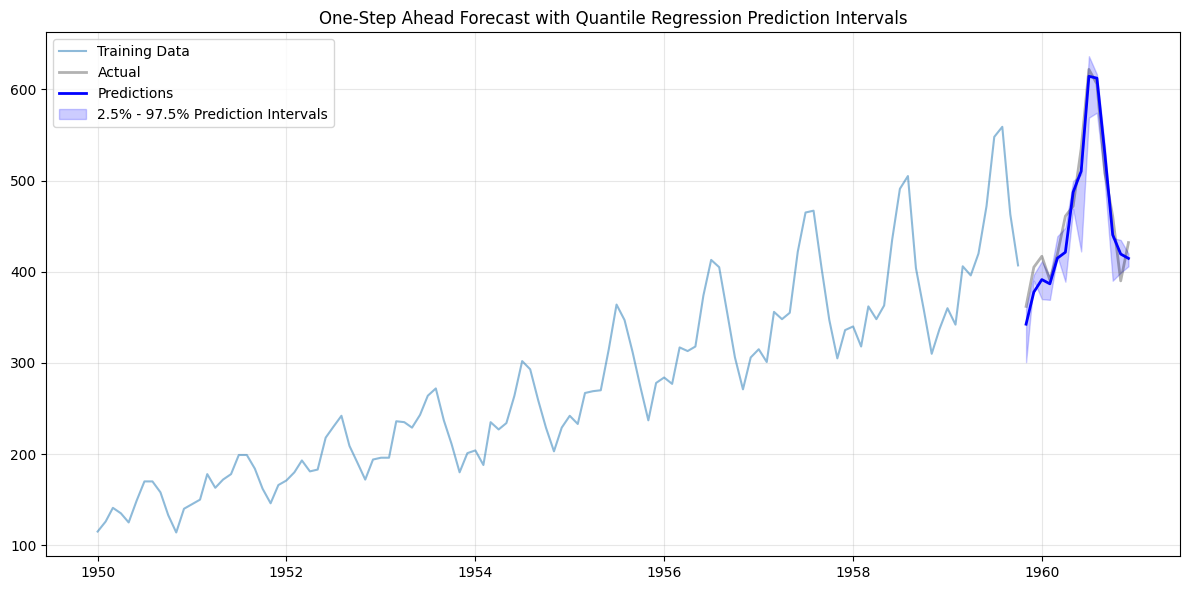


Summary Statistics:
MAPE: 4.22%
RMSE: 21.27


,actual,prediction,lower_bound,upper_bound
Month,,,,
1959-11-01,362,342.484111,300.825057,359.295389
1959-12-01,405,377.713347,390.204670,396.850103
1960-01-01,417,391.432745,369.979768,411.479336
1960-02-01,391,386.779072,369.209422,394.517625
1960-03-01,419,414.870473,417.150207,438.893575


In [12]:
results = create_1step_ahead_quantile_prediction_intervals(
    data=data,
    target_col='Passengers',
    n_lags=12,
    train_size=0.90,
    lower_q=0.025,
    upper_q=0.975
)

results.head()  

### Multi-step ahead prediction intervals

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor

def create_multistep_ahead_quantile_prediction_intervals(
    data,
    target_col,
    n_lags=12,
    train_size=0.90,
    fh=12,
    random_state=101,
    lower_q=0.025,
    upper_q=0.975
):
    """
    Create multi-step ahead prediction intervals using quantile regression
    
    Parameters:
    -----------
    data : pd.DataFrame or pd.Series
        Time series data
    target_col : str
        Name of target column (only needed if data is DataFrame)
    n_lags : int
        Number of lags to create
    train_size : float
        Proportion of data to use for training (0 to 1)
    fh : int
        Forecast horizon (number of steps ahead to predict)
    random_state : int
        Random seed for reproducibility
    lower_q : float
        Lower quantile (e.g., 0.025 for 95% interval)
    upper_q : float
        Upper quantile (e.g., 0.975 for 95% interval)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing predictions and prediction intervals
    """
    # Set random seed
    np.random.seed(random_state)
    
    # Convert to series if DataFrame
    if isinstance(data, pd.DataFrame):
        series = data[target_col]
    else:
        series = data
        
    # Create features
    df = pd.DataFrame()
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = series.shift(i)
    df['target'] = series
    df = df.dropna()
    
    # Split into X and y
    y = df['target']
    X = df.drop('target', axis=1)
    
    # Split into train/test
    train_size = int(len(X) * train_size)
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    
    print(f"Training set shape: {X_train.shape}")
    
    # Fit quantile regressors
    lower_model = QuantileRegressor(quantile=lower_q, alpha=0, solver='highs')
    upper_model = QuantileRegressor(quantile=upper_q, alpha=0, solver='highs')
    median_model = QuantileRegressor(quantile=0.5, alpha=0, solver='highs')
    
    # Fit models
    lower_model.fit(X_train, y_train)
    upper_model.fit(X_train, y_train)
    median_model.fit(X_train, y_train)
    
    # Make recursive predictions
    last_known = y_train.iloc[-n_lags:].values
    
    median_preds = []
    lower_preds = []
    upper_preds = []
    
    for step in range(fh):
        # Prepare features
        X_step = pd.DataFrame([{f'lag_{i+1}': last_known[-(i+1)] 
                              for i in range(n_lags)}])
        
        # Ensure columns are in the same order as training data
        X_step = X_step[X_train.columns]
        
        # Make predictions
        median_pred = median_model.predict(X_step)[0]
        lower_pred = lower_model.predict(X_step)[0]
        upper_pred = upper_model.predict(X_step)[0]
        
        # Store predictions
        median_preds.append(median_pred)
        lower_preds.append(lower_pred)
        upper_preds.append(upper_pred)
        
        # Update last known values for next step
        last_known = np.append(last_known[1:], median_pred)
    
    # Create future dates for predictions
    if isinstance(y_train.index, pd.PeriodIndex):
        future_dates = pd.period_range(
            start=y_train.index[-1] + 1,
            periods=fh,
            freq=y_train.index.freq
        )
        plot_dates = future_dates.to_timestamp()
        y_train_plot = y_train.copy()
        y_train_plot.index = y_train.index.to_timestamp()
    else:
        freq = pd.infer_freq(y_train.index)
        future_dates = pd.date_range(
            start=y_train.index[-1],
            periods=fh + 1,
            freq=freq
        )[1:]
        plot_dates = future_dates
        y_train_plot = y_train
    
    # Create results DataFrame
    results = pd.DataFrame({
        'prediction': median_preds,
        'lower_bound': lower_preds,
        'upper_bound': upper_preds
    }, index=future_dates)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot all training data
    plt.plot(y_train_plot.index, y_train_plot, label='Training Data', alpha=0.5)

    # Plot the actual values
    plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2, alpha=0.3)
    
    # Plot predictions and intervals
    plt.plot(plot_dates, median_preds, 
             label='Predictions', color='blue', linewidth=2)
    plt.fill_between(plot_dates, lower_preds, upper_preds, 
                     alpha=0.2, color='blue', 
                     label=f'{lower_q*100}% - {upper_q*100}% Prediction Intervals')
    
    plt.title('Multi-step Ahead Forecast with Quantile Regression Prediction Intervals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of predictions
    print("\nForecast Summary:")
    print(results.head())
    
    return results

Training set shape: (118, 12)


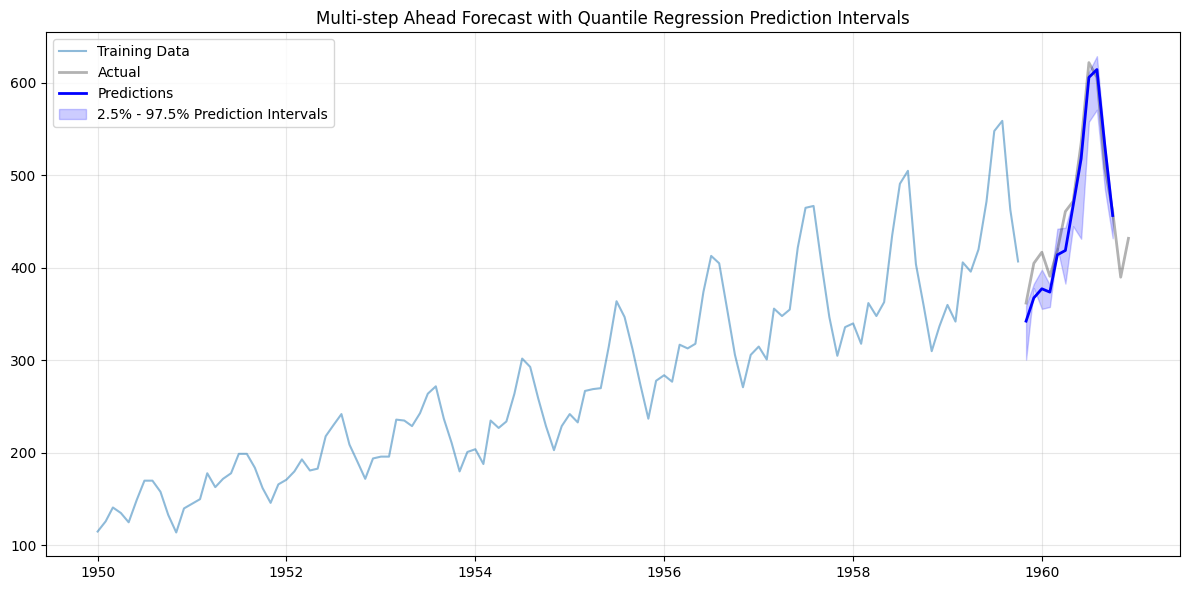


Forecast Summary:
            prediction  lower_bound  upper_bound
1959-11-01  342.484111   300.825057   359.295389
1959-12-01  367.596767   378.260133   382.841689
1960-01-01  377.461915   355.703883   398.129114
1960-02-01  373.858302   357.812999   381.603318
1960-03-01  414.179807   421.787149   442.388583


,prediction,lower_bound,upper_bound
1959-11-01,342.484111,300.825057,359.295389
1959-12-01,367.596767,378.260133,382.841689
1960-01-01,377.461915,355.703883,398.129114
1960-02-01,373.858302,357.812999,381.603318
1960-03-01,414.179807,421.787149,442.388583


In [14]:
results = create_multistep_ahead_quantile_prediction_intervals(
    data=data,
    target_col='Passengers',
    n_lags=12,
    train_size=0.90,
    fh=12,
    lower_q=0.025,
    upper_q=0.975
)

results.head()

Here's a summary of what we've accomplished:

1. Bootstrap Prediction Intervals:

* One-step ahead forecasting with bootstrap sampling
* Multi-step ahead forecasting with recursive predictions
* Captures model uncertainty through resampling


2. Quantile Regression Intervals:


* One-step ahead with direct quantile estimation
* Multi-step ahead with recursive quantile forecasting
* Potentially better at capturing heteroscedasticity

Key differences:

* Bootstrap is more computationally intensive but works with any model
* Quantile regression is faster but limited to linear relationships
* Bootstrap requires multiple model fits
* Quantile directly estimates the intervals

## 3. Conformal Prediction

For time series, conformal prediction provides a way to create prediction intervals that adapt to changes in the data over time, giving you confidence bounds around each forecasted point. Here's how it works in this setting:

Model Training: Start by training a standard time series forecasting model (e.g., ARIMA, neural networks) on historical data.

Calibration on Past Forecast Errors: Use a recent subset of past data (the "calibration set") to generate predictions and calculate the errors (residuals) of these predictions. These errors provide an estimate of the model’s uncertainty.

Building Prediction Intervals: Using the spread of these past errors, conformal prediction creates intervals around future predictions. For example, if you want a 90% prediction interval, it adjusts the width based on the observed errors so that 90% of the actual values should fall within this interval.

Dynamic Adaptation: This approach adapts to different levels of uncertainty in your time series data. If the recent data is more volatile, the prediction interval widens; if it's more stable, the interval narrows.

Conformal prediction for time series is especially helpful when you need consistent, reliable intervals in unpredictable environments, as it provides flexible bounds without assuming a specific distribution.

In [15]:
# preparing the data

def create_features(data, n_lags=12):
    """
    Create lag features from time series data
    """
    df = pd.DataFrame()
    
    # Create lag features
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = data.shift(i)
    
    # Add target
    df['target'] = data
    
    # Remove rows with NaN values
    df = df.dropna()
    
    # Split into X and y
    y = df['target']
    X = df.drop('target', axis=1)
    
    return X, y

# Load the data (assuming your data is in a DataFrame called 'data')
series = data['Passengers']

# Create features
X, y = create_features(series, n_lags=12)

# Split into train/test
train_size = int(len(X) * 0.90)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

X_train.head()


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Month,,,,,,,,,,,,
1950-01-01,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0
1950-02-01,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0
1950-03-01,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0
1950-04-01,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0
1950-05-01,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0


#### MAPIE (Model Agnostic Prediction Interval Estimator) python package
https://mapie.readthedocs.io/en/latest/

In the MAPIE package, one-step ahead and multi-step ahead prediction intervals for time series forecasting do differ in approach. The package natively supports one-step ahead forecasts, meaning each prediction provides an interval for the very next time step only. However, you can also configure MAPIE to handle multi-step forecasting by adapting predictions recursively.

For one-step ahead intervals, MAPIE's MapieTimeSeriesRegressor can calculate intervals by fitting the model on the training set and then using either the EnbPI or ACI methods for interval estimation. The intervals here are based on a single-step prediction without feedback from future steps. To apply this, you simply use .fit() on the training data, followed by .predict() for each next step in the test set.

For multi-step ahead intervals, MAPIE allows for recursive prediction, where each one-step forecast is fed as input for the subsequent prediction. This approach involves looping through the test set to make successive predictions and recalculating intervals dynamically with methods like partial_fit or adapt_conformal_inference. This configuration updates intervals with each step, adjusting for new data points and minimizing error accumulation over multiple steps

In [16]:
import mapie
print(mapie.__version__)

0.9.1


In [17]:
from mapie.regression import MapieTimeSeriesRegressor

https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieTimeSeriesRegressor.html

### One-step ahead prediction intervals

In [ ]:
# Create and fit the model
def create_onestep_ahead_conformal_prediction_intervals(
    data,
    target_col='passengers',
    model = RandomForestRegressor(), 
    n_lags=12,
    train_size=0.90,
    method='enbpi',
    random_state=42
):
    """
    Create one-step ahead prediction intervals using MAPIE
    
    Parameters:
    -----------
    data : pd.DataFrame
        Time series data
    target_col : str
        Name of target column
    n_lags : int
        Number of lags to create
    train_size : float
        Proportion of data to use for training
    method : str
        MAPIE method ('enbpi' or 'aci')
    random_state : int
        Random seed
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing actual values, predictions, and prediction intervals
    """
    # Prepare data
    series = data[target_col]
    
    # Create features
    df = pd.DataFrame()
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = series.shift(i)
    df['target'] = series
    df = df.dropna()
    
    # Split into X and y
    y = df['target']
    X = df.drop('target', axis=1)
    
    # Split into train/test
    train_size = int(len(X) * train_size)
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    # Create and fit model
    mapie = MapieTimeSeriesRegressor(
        model,
        method=method,
        cv=None,  
        n_jobs=-1
    )
    
    # Fit and predict
    mapie.fit(X_train, y_train)
    y_pred, y_pis = mapie.predict(X_test, alpha=0.05)  # 95% prediction interval
    
    # Create results DataFrame
    results = pd.DataFrame({
        'actual': y_test,
        'prediction': y_pred,
        'lower_bound': y_pis[:, 0, 0],
        'upper_bound': y_pis[:, 1, 0]
    }, index=y_test.index)
    
    # Calculate metrics
    mape = np.mean(np.abs((results['actual'] - results['prediction']) / results['actual'])) * 100
    rmse = np.sqrt(np.mean((results['actual'] - results['prediction'])**2))
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.plot(y_train.index, y_train, label='Training Data', alpha=0.5)
    
    # Plot test data and predictions
    plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2, alpha=0.3)
    plt.plot(y_test.index, y_pred, label='Predictions', color='blue', linewidth=2)
    
    # Plot prediction intervals
    plt.fill_between(y_test.index, 
                     y_pis[:, 0, 0], 
                     y_pis[:, 1, 0], 
                     alpha=0.2, color='blue', 
                     label='95% Prediction Intervals')
    
    plt.title(f'One-Step Ahead Forecast with Conformal Prediction Intervals ({method.upper()})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nSummary Statistics:")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:.2f}")
    print("\nFirst few predictions:")
    print(results.head())
    
    return results


Training set shape: (118, 12)
Test set shape: (14, 12)


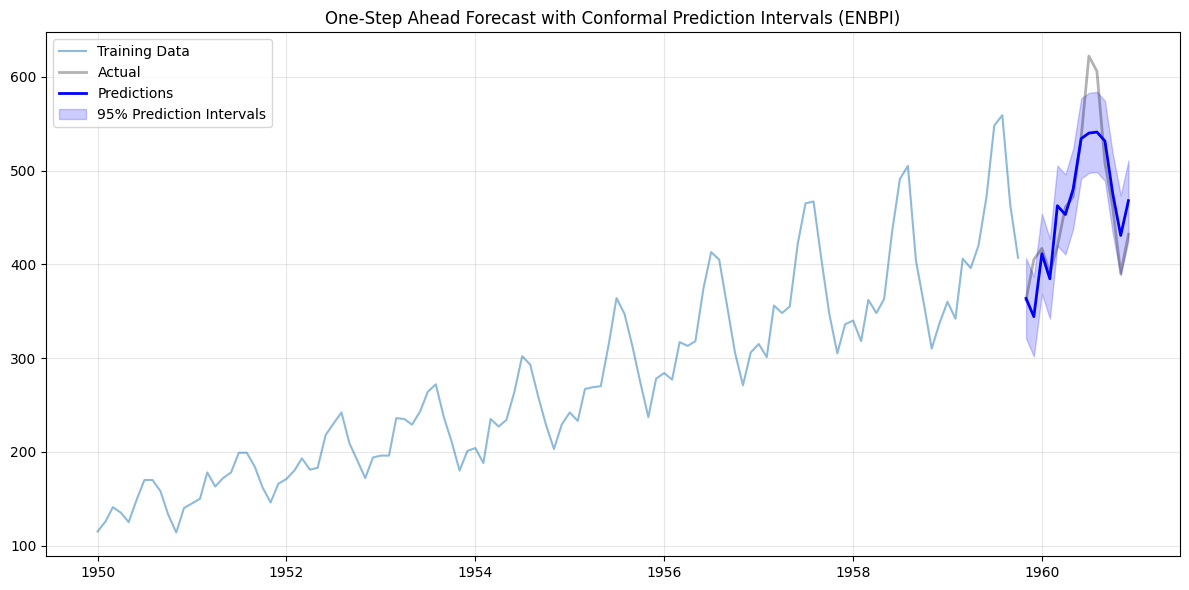


Summary Statistics:
MAPE: 5.93%
RMSE: 38.23

First few predictions:
            actual  prediction  lower_bound  upper_bound
Month                                                   
1959-11-01     362      363.55       321.00       406.43
1959-12-01     405      344.21       301.66       387.09
1960-01-01     417      411.31       368.76       454.19
1960-02-01     391      384.49       341.94       427.37
1960-03-01     419      462.46       419.91       505.34


In [22]:
# Example usage:
results = create_onestep_ahead_conformal_prediction_intervals(
    data=data,
    target_col='Passengers',
    model=RandomForestRegressor(),  
    n_lags=12,
    train_size=0.90,
    method='enbpi'
)

In [23]:
results.head()

,actual,prediction,lower_bound,upper_bound
Month,,,,
1959-11-01,362,363.55,321.00,406.43
1959-12-01,405,344.21,301.66,387.09
1960-01-01,417,411.31,368.76,454.19
1960-02-01,391,384.49,341.94,427.37
1960-03-01,419,462.46,419.91,505.34


### Multi-step ahead prediction intervals

In [29]:
from mapie.regression import MapieTimeSeriesRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_features(data, n_lags=12):
    """
    Create lag features from time series data
    """
    df = pd.DataFrame()
    
    # Create lag features
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = data.shift(i)
    
    # Add target
    df['target'] = data
    
    # Remove rows with NaN values
    df = df.dropna()
    
    # Split into X and y
    y = df['target']
    X = df.drop('target', axis=1)
    
    return X, y

def create_multistep_ahead_conformal_prediction_intervals(
    data,
    target_col='passengers',
    model = RandomForestRegressor(),    
    n_lags=12,
    train_size=0.90,
    fh=12,
    method='aci',
    random_state=42
):
    """
    Create multi-step ahead prediction intervals using MAPIE
    """
    # Prepare data
    series = data[target_col]
    X, y = create_features(series, n_lags=n_lags)
    
    # Split into train/test
    train_size = int(len(X) * train_size)
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    
    print(f"Training set shape: {X_train.shape}")
    
    # Create and fit model
    mapie = MapieTimeSeriesRegressor(
        model,
        method=method,
        cv=None,  
        n_jobs=-1,
    )
    
    # Fit model
    mapie.fit(X_train, y_train)
    
    # Prepare for recursive forecasting
    last_known = y_train.iloc[-n_lags:].values
    X_future = pd.DataFrame()
    
    predictions = []
    lower_bounds = []
    upper_bounds = []
    
    # Make recursive predictions
    for step in range(fh):
        # Prepare features
        X_step = pd.DataFrame([{f'lag_{i+1}': last_known[-(i+1)] 
                              for i in range(n_lags)}])
        
        # Ensure columns are in the same order as training data
        X_step = X_step[X_train.columns]
        
        # Make prediction with intervals
        y_pred, y_pis = mapie.predict(X_step, alpha=0.05)
        
        # Store predictions
        predictions.append(y_pred[0])
        lower_bounds.append(y_pis[0, 0, 0])
        upper_bounds.append(y_pis[0, 1, 0])
        
        # Update last known values
        last_known = np.append(last_known[1:], y_pred[0])
    
    # Create future dates
    if isinstance(y_train.index, pd.PeriodIndex):
        future_dates = pd.period_range(
            start=y_train.index[-1] + 1,
            periods=fh,
            freq=y_train.index.freq
        )
        plot_dates = future_dates.to_timestamp()
        y_train_plot = y_train.copy()
        y_train_plot.index = y_train.index.to_timestamp()
    else:
        freq = pd.infer_freq(y_train.index)
        future_dates = pd.date_range(
            start=y_train.index[-1],
            periods=fh + 1,
            freq=freq
        )[1:]
        plot_dates = future_dates
        y_train_plot = y_train
    
    # Create results DataFrame
    results = pd.DataFrame({
        'prediction': predictions,
        'lower_bound': lower_bounds,
        'upper_bound': upper_bounds
    }, index=future_dates)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot all training data
    plt.plot(y_train_plot.index, y_train_plot, label='Historical Data', alpha=0.5)

    # Plot the actual values
    plt.plot(y_test.index, y_test, label='Actual Data', alpha=0.7)
    
    # Plot predictions and intervals
    plt.plot(plot_dates, predictions, 
             label='Predictions', color='blue', linewidth=2)
    plt.fill_between(plot_dates, lower_bounds, upper_bounds, 
                     alpha=0.2, color='blue', 
                     label='95% Prediction Intervals')
    
    plt.title(f'Multi-step Ahead Forecast with Conformal Prediction Intervals ({method.upper()})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nForecast Summary:")
    print(results.head())
    
    return results


Training set shape: (118, 12)


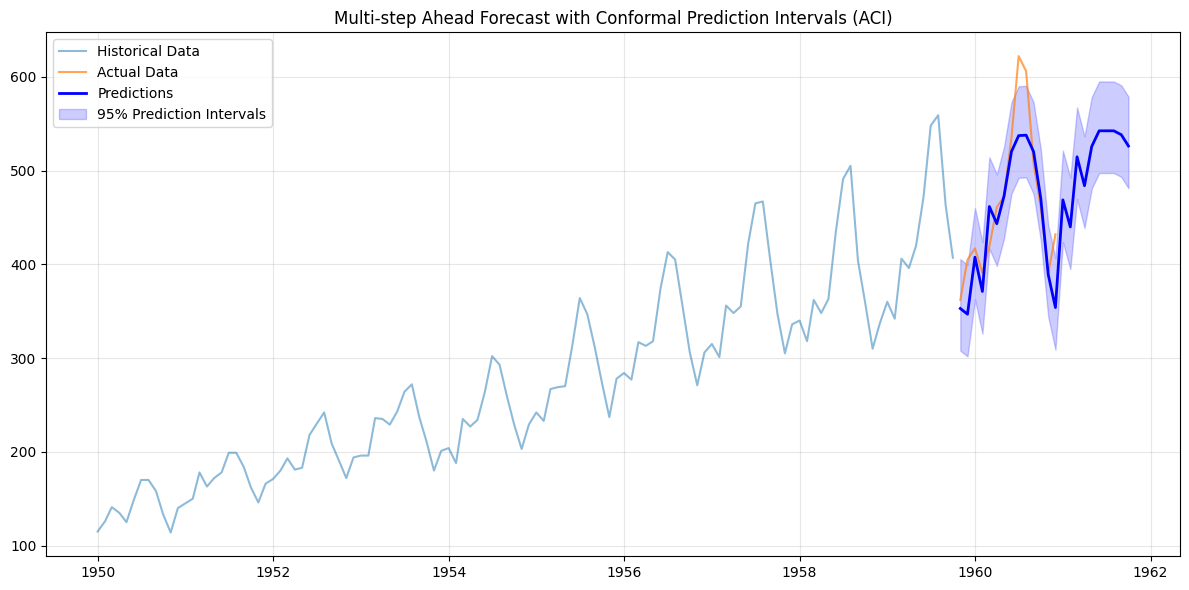


Forecast Summary:
            prediction  lower_bound  upper_bound
1959-11-01      352.87       307.86       405.50
1959-12-01      346.81       301.80       399.44
1960-01-01      407.57       362.56       460.20
1960-02-01      371.05       326.04       423.68
1960-03-01      461.60       416.59       514.23


In [31]:
# Example usage:
results = create_multistep_ahead_conformal_prediction_intervals(
    data=data,
    target_col='Passengers',
    model=RandomForestRegressor(),
    n_lags=12,
    train_size=0.90,
    fh=24,
    method='aci'
)

# Done!